## CAMELs sims

Just check we can load and plot the 2D CAMELs fields from IllustrisTNG

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from kymatio.numpy import Scattering2D
from sn_camels.models.models_factory import baseModelFactory, topModelFactory
from sn_camels.models.sn_hybrid_models import sn_HybridModel
import torch

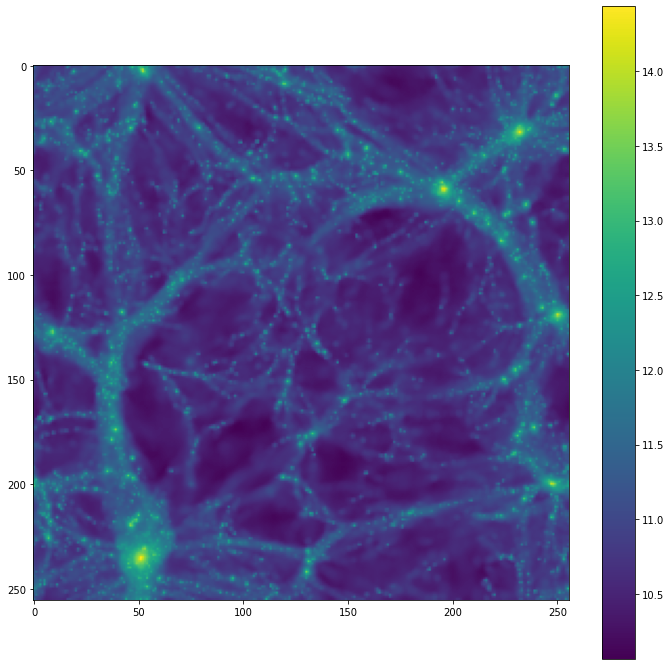

In [2]:
data_string=os.environ['CAMELS_PATH']+"/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy"
param_string=os.environ['CAMELS_PATH']+"/params_IllustrisTNG.txt"

## Import maps and parameters
maps = np.load(data_string)
params=np.loadtxt(param_string)

maps=maps[:10]

##Pick a field, any field
field_index=np.random.randint(len(maps))

plt.figure(figsize=(12,12))
plt.imshow(np.log10(maps[field_index]))
plt.colorbar()

/home/chris/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


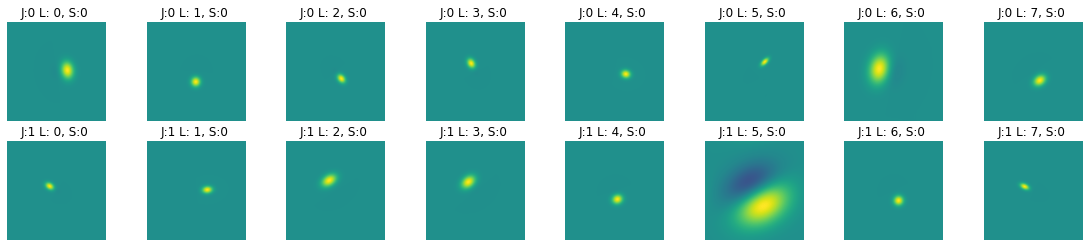

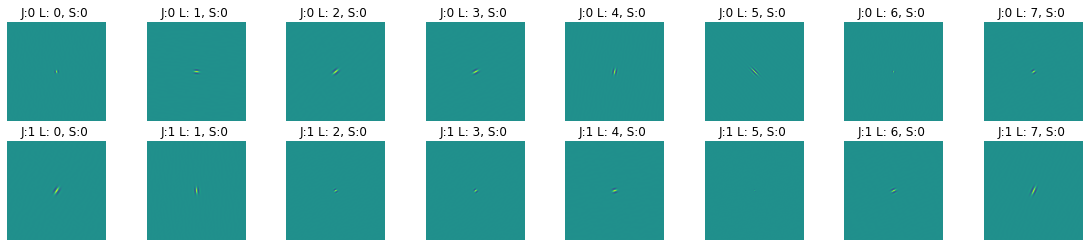

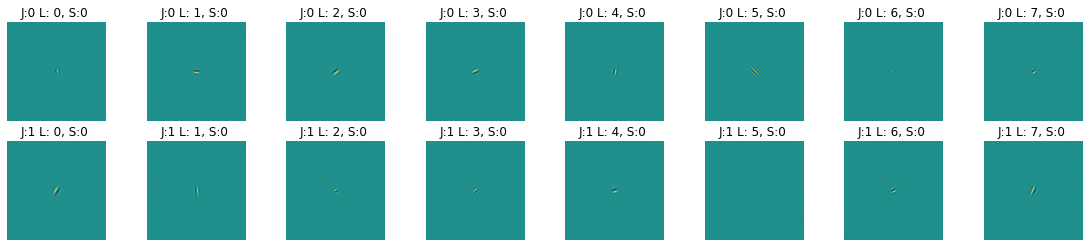

In [3]:
## Make one of our sn_camels models

scatteringBase = baseModelFactory( #creat scattering base model
    architecture='scattering',
    J=2,
    N=256,
    M=256,
    second_order=True,
    initialization="Random",
    seed=123,
    learnable=False,
    lr_orientation=0.1,
    lr_scattering=0.1,
    filter_video=False,
    device="cpu",
    use_cuda=False
)

top = topModelFactory( #create cnn, mlp, linearlayer, or other
    base=scatteringBase,
    architecture="linear_layer",
    num_classes=12, 
    width=8, 
    use_cuda=False
)

hybridModel = sn_HybridModel(scatteringBase=scatteringBase, top=top, use_cuda=False) #creat hybrid model

In [12]:
def scattering2d_learn(x, pad, unpad, backend, J, L, phi, psi, max_order,
        out_type='array'):
    """ Function to take an input image and perform a series of scattering
    convolutions."""
    subsample_fourier = backend.subsample_fourier
    modulus = backend.modulus
    fft = backend.fft
    cdgmm = backend.cdgmm
    concatenate = backend.concatenate

    # Define lists for output.
    out_S_0, out_S_1, out_S_2 = [], [], []
    
    ## Map to complex
    complex_maps = x.new_zeros(x.shape + (2,))
    complex_maps[..., 0] = x

    U_0_c = fft(complex_maps, 'C2C')

    # First low pass filter
    U_1_c = cdgmm(U_0_c, phi[0])
    #U_1_c = subsample_fourier(U_1_c, k=2 ** J)


    S_0 = fft(U_1_c, 'C2R', inverse=True)

    out_S_0.append({'coef': S_0,
                    'j': (),
                    'theta': ()})

    for n1 in range(len(psi)):
        j1 = psi[n1]['j'] ## don't care about this any more
        theta1 = psi[n1]['theta']

        ## Wavelet convolution
        U_1_c = cdgmm(U_0_c, psi[n1][0])

        U_1_c = fft(U_1_c, 'C2C', inverse=True)
        U_1_c = modulus(U_1_c)
        U_1_c = fft(U_1_c, 'C2C')

        ## Second low pass filter
        S_1_c = cdgmm(U_1_c, phi[0])
        ## No subsampling for now
        #S_1_c = subsample_fourier(S_1_c, k=2 ** (J))

        S_1_r = fft(S_1_c, 'C2R', inverse=True)

        out_S_1.append({'coef': S_1_r,
                        'j': (j1,),
                        'theta': (theta1,)})

        if max_order < 2:
            continue
        for n2 in range(len(psi)):
            j2 = psi[n2]['j']
            theta2 = psi[n2]['theta']
            

            U_2_c = cdgmm(U_1_c, psi[n2][0])
            # No subsampling for now
            #U_2_c = subsample_fourier(U_2_c, k=2 ** (j2 - j1))
            U_2_c = fft(U_2_c, 'C2C', inverse=True)
            U_2_c = modulus(U_2_c)
            U_2_c = fft(U_2_c, 'C2C')

            ## Low pass filter
            S_2_c = cdgmm(U_2_c, phi[0])
            
            # No subsampling for now
            #S_2_c = subsample_fourier(S_2_c, k=2 ** (J - j2))

            S_2_r = fft(S_2_c, 'C2R', inverse=True)
            

            out_S_2.append({'coef': S_2_r,
                            'j': (j1, j2),
                            'theta': (theta1, theta2)})

    out_S = []
    out_S.extend(out_S_0)
    out_S.extend(out_S_1)
    out_S.extend(out_S_2)

    if out_type == 'array':
        out_S = concatenate([x['coef'] for x in out_S])

    return out_S

In [13]:
out=scattering2d_learn(torch.tensor(maps), scatteringBase.scattering.pad, scatteringBase.scattering.unpad, scatteringBase.scattering.backend, scatteringBase.scattering.J,
                        scatteringBase.scattering.L, scatteringBase.scattering.phi, scatteringBase.scattering.psi, scatteringBase.scattering.max_order, scatteringBase.scattering.out_type)

## Plot some first order convolutions

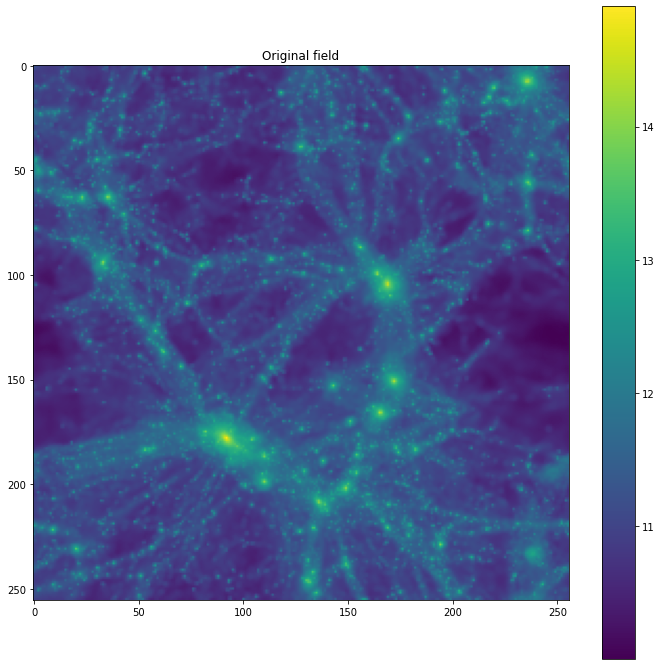

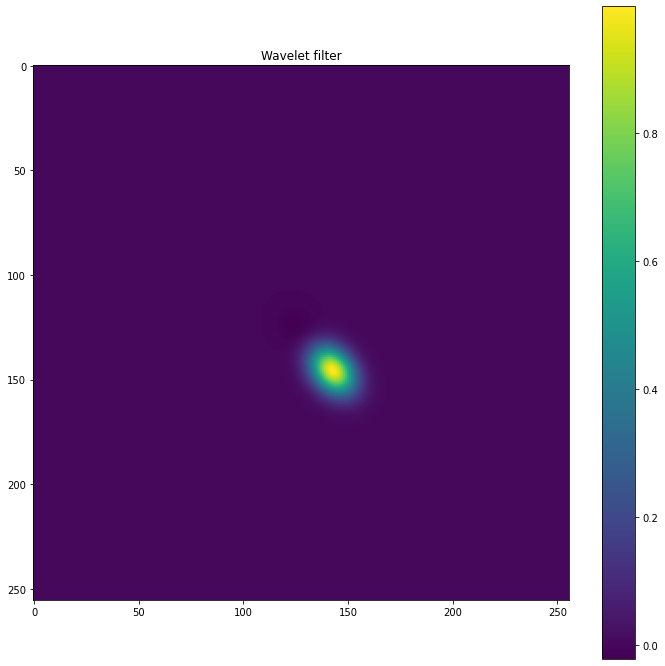

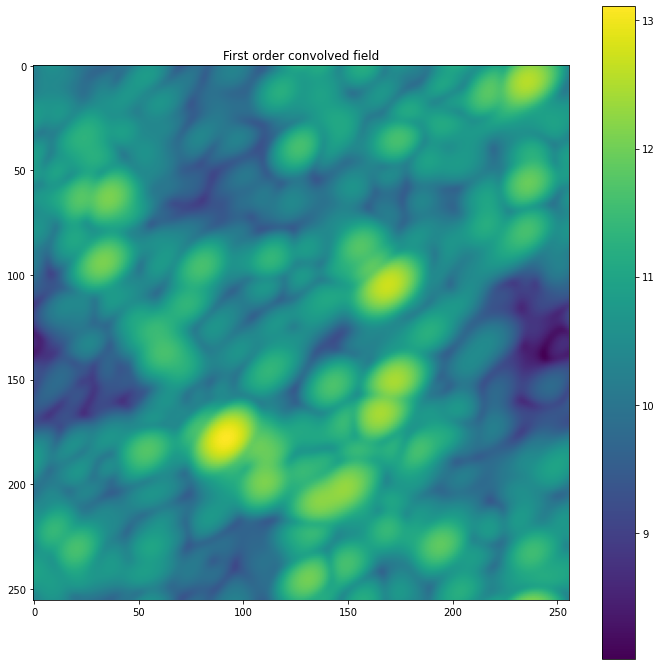

In [38]:
filter_num=2 # between 1 and 16
cdm_map_num=0 # between 0 and 10
plt.figure(figsize=(12,12))
plt.title("Original field")
plt.imshow(np.log10(maps[cdm_map_num]))
plt.colorbar()
plt.figure(figsize=(12,12))
plt.title("Wavelet filter")
plt.imshow(np.fft.fftshift(scatteringBase.scattering.psi[filter_num][0]))
plt.colorbar()
plt.figure(figsize=(12,12))
plt.title("First order convolved field")
plt.imshow(np.log10(out[cdm_map_num][filter_num+1]))
plt.colorbar()

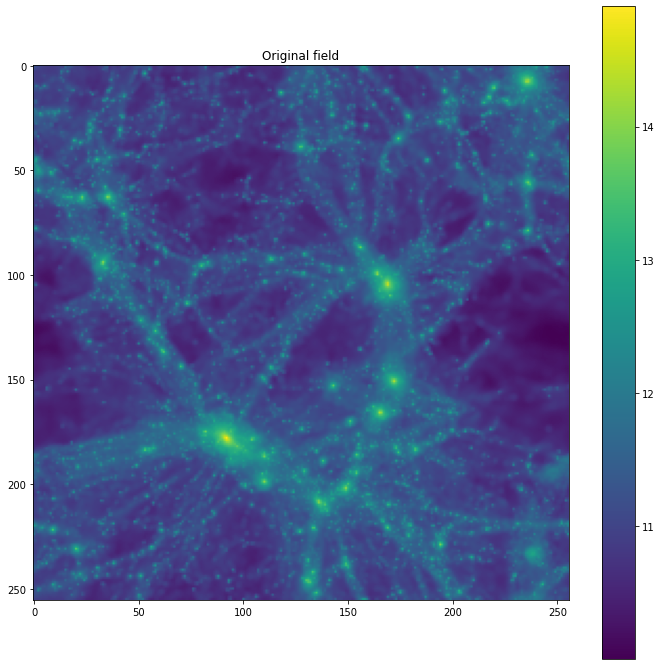

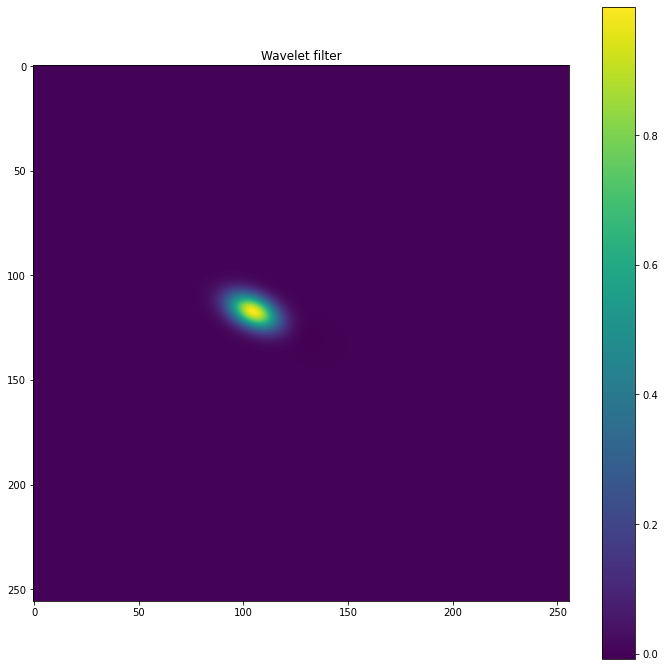

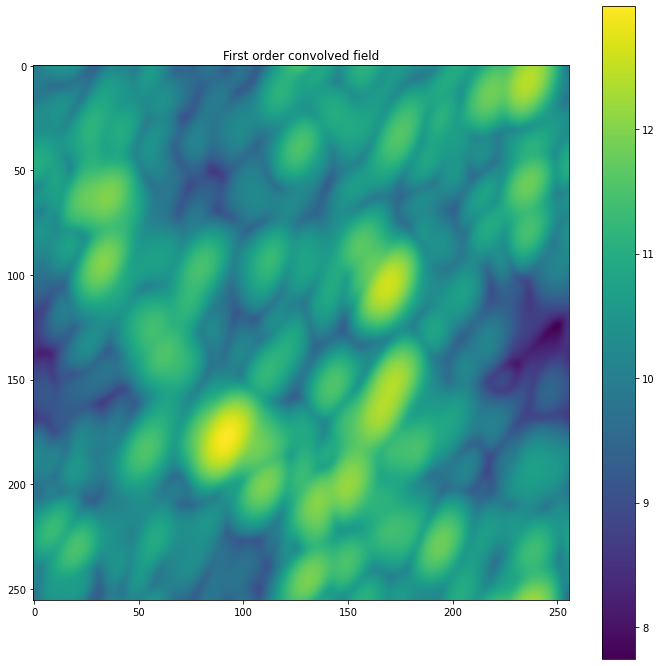

In [40]:
filter_num=15 # between 1 and 16
cdm_map_num=0 # between 0 and 10
plt.figure(figsize=(12,12))
plt.title("Original field")
plt.imshow(np.log10(maps[cdm_map_num]))
plt.colorbar()
plt.figure(figsize=(12,12))
plt.title("Wavelet filter")
plt.imshow(np.fft.fftshift(scatteringBase.scattering.psi[filter_num][0]))
plt.colorbar()
plt.figure(figsize=(12,12))
plt.title("First order convolved field")
plt.imshow(np.log10(out[cdm_map_num][filter_num+1]))
plt.colorbar()

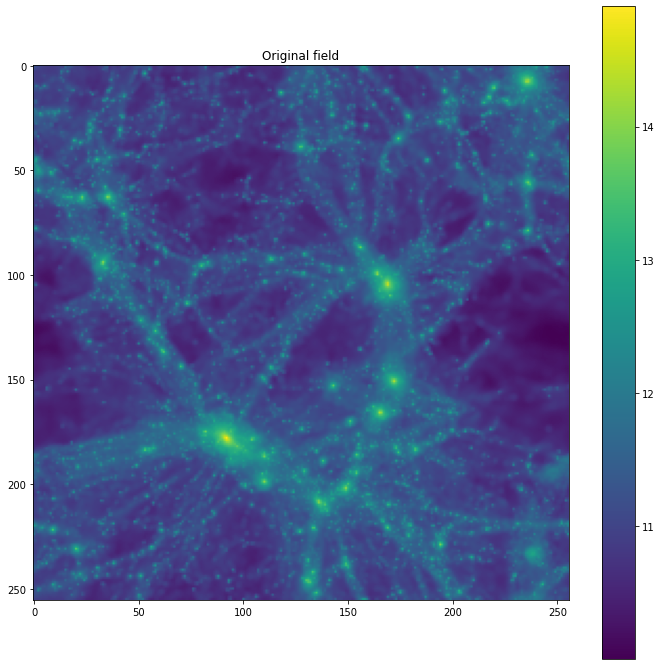

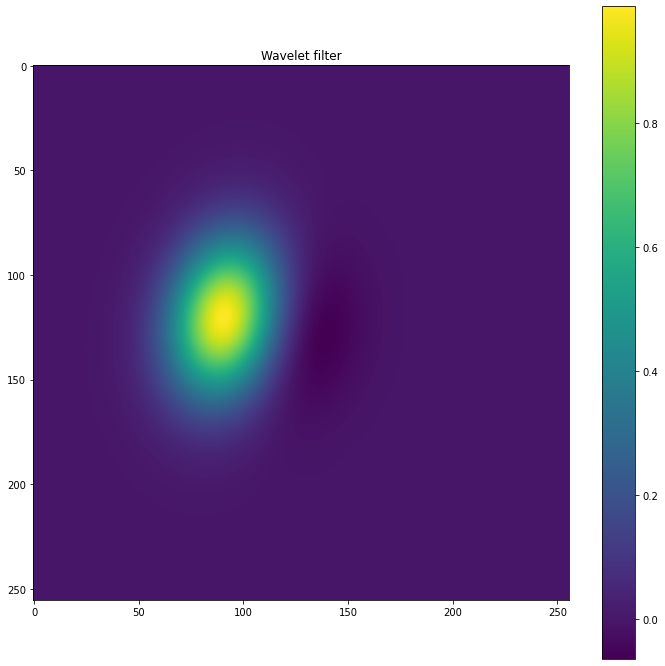

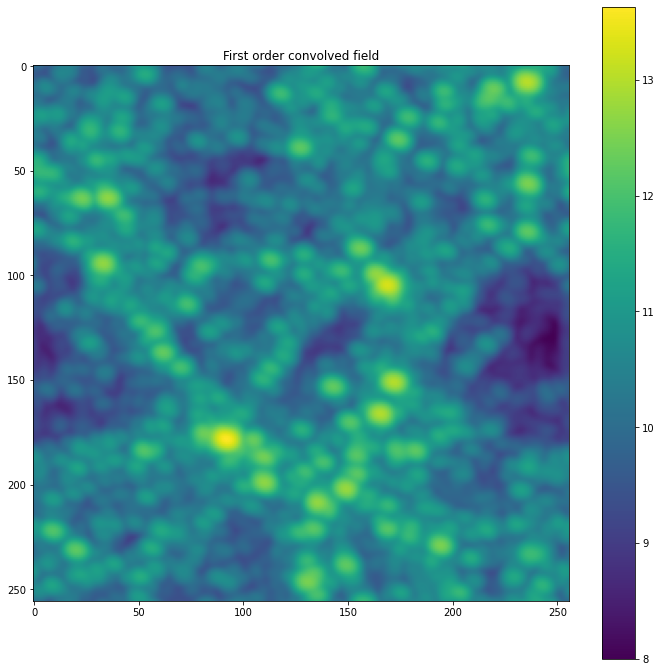

In [41]:
filter_num=6 # between 1 and 16
cdm_map_num=0 # between 0 and 10
plt.figure(figsize=(12,12))
plt.title("Original field")
plt.imshow(np.log10(maps[cdm_map_num]))
plt.colorbar()
plt.figure(figsize=(12,12))
plt.title("Wavelet filter")
plt.imshow(np.fft.fftshift(scatteringBase.scattering.psi[filter_num][0]))
plt.colorbar()
plt.figure(figsize=(12,12))
plt.title("First order convolved field")
plt.imshow(np.log10(out[cdm_map_num][filter_num+1]))
plt.colorbar()